In [2]:
import pandas as pd
from scipy.stats import chi2_contingency, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

airbnb_data = pd.read_csv("cleaned_airbnb_Chicago.csv")

Plain optimisation of the consolidated score

17031300500.0 386.6666666666667


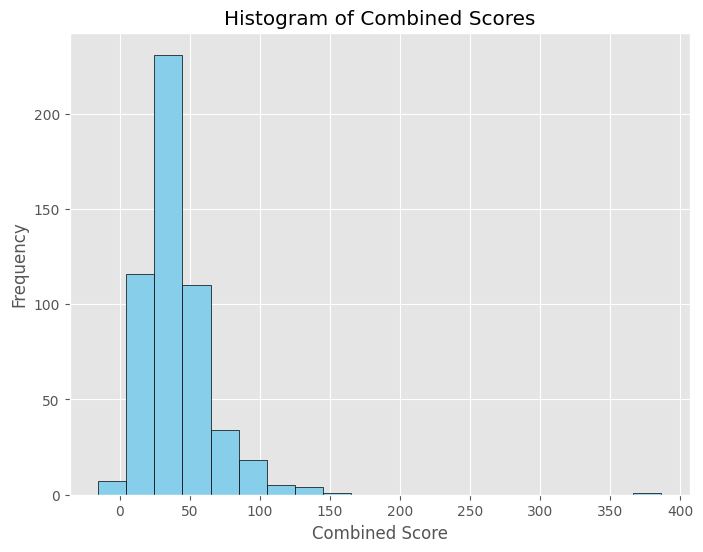

In [5]:
############################
from sklearn.preprocessing import MinMaxScaler


airbnb_data['booking_rate'] = (airbnb_data['booked_days'] / airbnb_data['available_days']) * 100
airbnb_data['tract_hosts'] = (airbnb_data['tract_superhosts'] / airbnb_data['tract_superhosts_ratio']) * 100

# Calculating normalized metrics for bookings and cancellations per population
tract_metrics = airbnb_data.groupby('census_tract').agg({
    'numReservedDays_pastYear': 'sum',
    'numCancel_pastYear': 'sum',
    'tract_housing_units' : 'sum',
    'revenue' : 'sum',
    'tract_superhosts' : 'sum',
    'tract_hosts':'sum',
    'booking_rate':'mean',
    'tract_total_pop': 'mean'
}).reset_index()

# filtering
tract_metrics = tract_metrics[tract_metrics['tract_hosts'] != 0]


tract_metrics['booking_rate_per_host'] = tract_metrics['booking_rate'] / tract_metrics['tract_hosts']
tract_metrics['revenue_per_host'] = tract_metrics['revenue'] / tract_metrics['tract_hosts']
tract_metrics['superhosts_per_host'] = tract_metrics['tract_superhosts'] / tract_metrics['tract_hosts']
tract_metrics['cancellations_per_host'] = tract_metrics['numCancel_pastYear'] / tract_metrics['tract_hosts']
tract_metrics['reservations_per_host'] = tract_metrics['numReservedDays_pastYear'] / tract_metrics['tract_hosts']



# Select the columns you want to normalize
columns_to_normalize = [
    'booking_rate_per_host',
    'revenue_per_host',
    'superhosts_per_host',
    'reservations_per_host',
    'cancellations_per_host'
]

# Create a MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 100))

# Apply Min-Max scaling to the selected columns
tract_metrics[columns_to_normalize] = scaler.fit_transform(tract_metrics[columns_to_normalize])



# Combined score per host
tract_metrics['combined_score_per_host'] = (
    tract_metrics['booking_rate_per_host'] +
    tract_metrics['revenue_per_host'] +
    tract_metrics['superhosts_per_host'] +
    tract_metrics['reservations_per_host'] -
    tract_metrics['cancellations_per_host']
)

# Identifying the tract with the highest combined score
optimal_tract = tract_metrics.sort_values(by='combined_score_per_host', ascending=False).iloc[0]
optimal_tract_id = optimal_tract['census_tract']
optimal_tract_score = optimal_tract['combined_score_per_host']

print(optimal_tract_id, optimal_tract_score)


# Create a histogram of the combined scores
plt.figure(figsize=(8, 6))
plt.style.use('ggplot')
plt.hist(tract_metrics['combined_score_per_host'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Combined Score')
plt.ylabel('Frequency')
plt.title('Histogram of Combined Scores')
plt.show()

In [12]:
# Define the threshold score
threshold_score = 200

# Create a mask to identify tracts with scores greater than or equal to the threshold
high_score_mask = tract_metrics['combined_score_per_host'] >= threshold_score

# Split the tracts into two clusters based on the mask
high_score_tracts = tract_metrics[high_score_mask]
low_score_tracts = tract_metrics[~high_score_mask]

# Get the counts and means for both clusters
count_high_score = len(high_score_tracts)
mean_high_score = high_score_tracts['combined_score_per_host'].mean()

count_low_score = len(low_score_tracts)
mean_low_score = low_score_tracts['combined_score_per_host'].mean()

# Print the counts and means for both clusters
print(f"Cluster 1 - High Scores:")
print(f"Count: {count_high_score}")
print(f"Mean Score: {mean_high_score}")

print("\n")

print(f"Cluster 2 - Lower Scores:")
print(f"Count: {count_low_score}")
print(f"Mean Score: {mean_low_score}")


Cluster 1 - High Scores:
Count: 1
Mean Score: 386.6666666666667


Cluster 2 - Lower Scores:
Count: 526
Mean Score: 40.55383059709374


Combining multiple binary clusters to find overlap

In [6]:
from sklearn.cluster import KMeans

# Assuming 'tract_metrics' DataFrame already has the new variables calculated

# List of new variables for clustering
new_vars_for_clustering = [
    'booking_rate_per_host',
    'revenue_per_host',
    'superhosts_per_host',
    'reservations_per_host',
    'cancellations_per_host'
]

# Normalizing the new data
new_data_normalized = tract_metrics[new_vars_for_clustering].apply(lambda x: (x - x.mean()) / x.std())

# Applying K-Means clustering to each new variable
# We use 2 clusters: one for high and one for low values for each parameter
kmeans_results = {}
for var in new_vars_for_clustering:
    kmeans = KMeans(n_clusters=2, random_state=0).fit(new_data_normalized[[var]])
    tract_metrics[var + '_cluster'] = kmeans.labels_
    kmeans_results[var] = kmeans

# Identify the high value cluster for each variable
# Assuming that for booking rate, revenue, superhosts, and reservations, the higher cluster is better (higher mean is better)
# For cancellations, the lower cluster is better (lower mean is better)
high_value_clusters = {}
for var in new_vars_for_clustering:
    if var == 'cancellations_per_host':
        # For cancellations, we want the cluster with the lower mean
        high_value_clusters[var] = tract_metrics.groupby(var + '_cluster')[var].mean().idxmin()
    else:
        # For all other variables, we want the cluster with the higher mean
        high_value_clusters[var] = tract_metrics.groupby(var + '_cluster')[var].mean().idxmax()

# Finding the common tracts that fall into the desirable clusters for all variables
optimal_tracts = tract_metrics.copy()
for var, cluster in high_value_clusters.items():
    optimal_tracts = optimal_tracts[optimal_tracts[var + '_cluster'] == cluster]

# Select only the census_tract and the new variables for clustering
optimal_tracts = optimal_tracts[['census_tract'] + new_vars_for_clustering]

optimal_tracts


c:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  s

,census_tract,booking_rate_per_host,revenue_per_host,superhosts_per_host,reservations_per_host,cancellations_per_host
319,17031300500,100.0,100.0,100.0,100.0,13.333333


Plain Clustering from samridhi

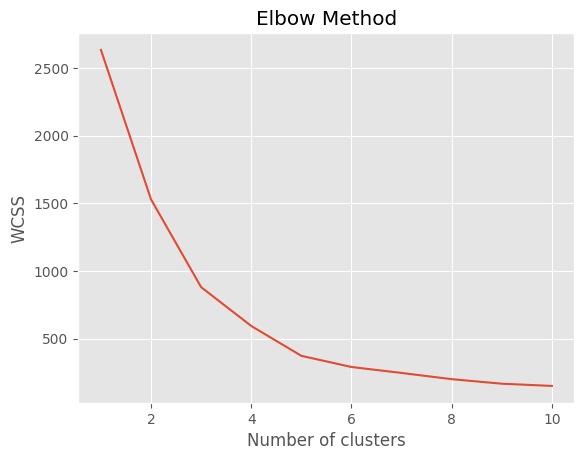

Cluster centers (in the original feature space):
   booking_rate_per_host  revenue_per_host  superhosts_per_host  \
0               1.028510          0.432229            38.175886   
1             100.000000        100.000000           100.000000   
2              46.662498         12.742170            92.132505   

   reservations_per_host  cancellations_per_host  
0               0.028495                0.512315  
1             100.000000               13.333333  
2               0.238468               30.740741  


Cluster
0    517
1      1
2      9
Name: census_tract, dtype: int64


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import numpy as np

features = ['booking_rate_per_host',
    'revenue_per_host',
    'superhosts_per_host',
    'reservations_per_host',
    'cancellations_per_host']


X = tract_metrics[features]
 
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Imputed with median
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
X_imputed = imputer.fit_transform(X_scaled)
 
# Determine the optimal number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_imputed)
    wcss.append(kmeans.inertia_)
 
# Plot the elbow graph
plt.plot(range(1, 11), wcss)
plt.style.use('ggplot')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()
 
# Assuming the elbow point is at 3 clusters (this should be determined by observing the plot)
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters = kmeans.fit_predict(X_imputed)
 
# Add the cluster data to the original DataFrame
tract_metrics['Cluster'] = clusters
 
# Invert the scale transformation on cluster centers
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
 
# Create a DataFrame for cluster center features for better interpretability
cluster_centers_df = pd.DataFrame(cluster_centers, columns=features)
print("Cluster centers (in the original feature space):")
print(cluster_centers_df)

print("\n")


tract_counts_per_cluster = tract_metrics.groupby('Cluster')['census_tract'].nunique()
print(tract_counts_per_cluster)

In [19]:
# Grouping the DataFrame by 'Cluster' and listing tracts in each cluster
tracts_per_cluster = tract_metrics.groupby('Cluster')['census_tract'].apply(list)

# Display the tracts for each cluster
for cluster, tracts in tracts_per_cluster.items():
    print(f"Cluster {cluster}:")
    print(tracts)
    print() 

Cluster 0:
[17031010100, 17031010201, 17031010202, 17031010300, 17031010400, 17031010501, 17031010502, 17031010503, 17031010600, 17031010701, 17031010702, 17031020100, 17031020200, 17031020301, 17031020400, 17031020500, 17031020601, 17031020602, 17031020701, 17031020702, 17031020801, 17031020802, 17031020901, 17031020902, 17031030101, 17031030102, 17031030103, 17031030200, 17031030300, 17031030400, 17031030500, 17031030601, 17031030603, 17031030604, 17031030701, 17031030703, 17031030706, 17031030800, 17031030900, 17031031000, 17031031100, 17031031200, 17031031300, 17031031400, 17031031501, 17031031502, 17031031700, 17031031800, 17031031900, 17031032100, 17031040100, 17031040201, 17031040202, 17031040300, 17031040401, 17031040402, 17031040600, 17031040700, 17031040800, 17031040900, 17031050100, 17031050200, 17031050300, 17031050500, 17031050600, 17031050700, 17031050800, 17031050900, 17031051000, 17031051100, 17031051200, 17031051300, 17031051400, 17031060100, 17031060200, 17031060300, 